In [55]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tqdm import tqdm
import os
import cv2

# Image Processing

In [102]:
# Input Folders
main_folder = 'dataset/traffic_object_detection'
train_folder = f'{main_folder}/train'
test_folder = f'{main_folder}/test'
valid_folder = f'{main_folder}/valid'

# Output Folders
output_folder = 'dataset/traffic_object_detection_processed'
output_train_folder = f'{output_folder}/train'
output_test_folder = f'{output_folder}/test'
output_valid_folder = f'{output_folder}/valid'

classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
colors = [[0, 255, 0], [255, 0, 0], [0, 255, 0], [200, 200, 0], [200, 200, 200]]

In [103]:
def upscale_points(image, coordinates):
    x = int(coordinates[1] * image.shape[0])
    y = int(coordinates[2] * image.shape[1])
    width = int(coordinates[3] * image.shape[0])
    height = int(coordinates[4] * image.shape[1])
    return (int(coordinates[0]), x, y, width, height)

def draw_boundary(image, color, coordinates):
    (object_class, x, y, width, height) = upscale_points(image, coordinates)
    image[y-height:y-height+5, x-width:x+width, :] = color
    image[y-height:y+height, x+width:x+width+5, :] = color
    image[y+height-5:y+height, x-width:x+width, :] = color
    image[y-height:y+height, x-width-5:x-width, :] = color
    return image, (int(coordinates[0]), x, y, width, height)

def clip(value, prev_min, prev_max, new_min, new_max):
    return int((((value - prev_min) * (new_max - new_min)) / (prev_max - prev_min)) + new_min)

## Data Display

aguanambi-1085_png_jpg.rf.9560a8e9822039cd2b4566dd71f288a7.txt aguanambi-1085_png_jpg.rf.9560a8e9822039cd2b4566dd71f288a7.jpg


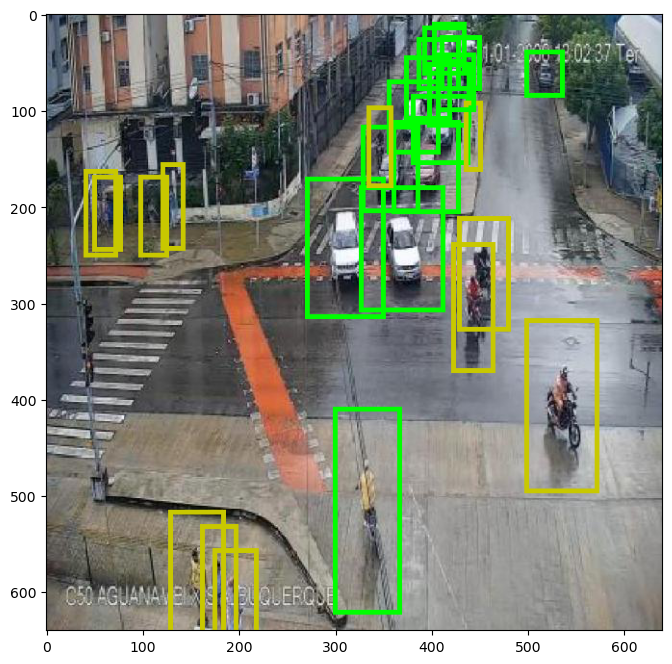

In [104]:
# Loading data
image_index = 4
images = os.listdir(f'{train_folder}/images')
labels = os.listdir(f'{train_folder}/labels')
image = plt.imread(f'{train_folder}/images/{images[image_index]}')
label = ''
object_coordinates = []
with open(f'{train_folder}/labels/{labels[image_index]}', 'r') as file:
    label = file.readlines()
new_image = image.copy()
for lab in label:
    coordinates = [float(num) for num in lab.split(' ')]
    new_image, coords = draw_boundary(new_image, colors[int(coordinates[0])], coordinates)
    object_coordinates.append(coords)

print(labels[image_index], images[image_index])

plt.figure(figsize=(8, 8))
plt.imshow(new_image)

In [105]:
def load_image(images, labels, index):
    image = plt.imread(f'{train_folder}/images/{images[index]}')
    object_coordinates = []
    with open(f'{train_folder}/labels/{labels[index]}', 'r') as file:
        label = file.readlines()
    for lab in label:
        coordinates = [float(num) for num in lab.split(' ')]
        coords = upscale_points(image, coordinates)
        object_coordinates.append(coords)
    return image, object_coordinates


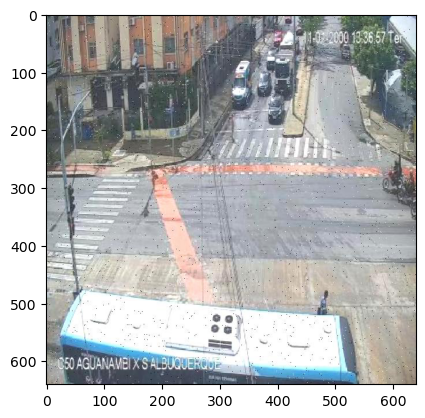

In [106]:
t_image, t_coords = load_image(images, labels, 500)
plt.imshow(t_image)

# Defining Data Generator

In [107]:
# Generates anchor points accross the image
def generate_anchor_points(image, stride = 5):
    anchor_points = []
    for i in range(stride, image.shape[0], stride):
        for j in range(stride, image.shape[1], stride):
            anchor_points.append([i, j])
    return anchor_points

def add_anchor_points(image, points, point_size = 5): 
    new_image = image.copy()
    for point in points:
        new_image[point[0] - point_size : point[0] + point_size, point[1] - point_size : point[1] + point_size, :] = [255, 255, 0]
    return new_image

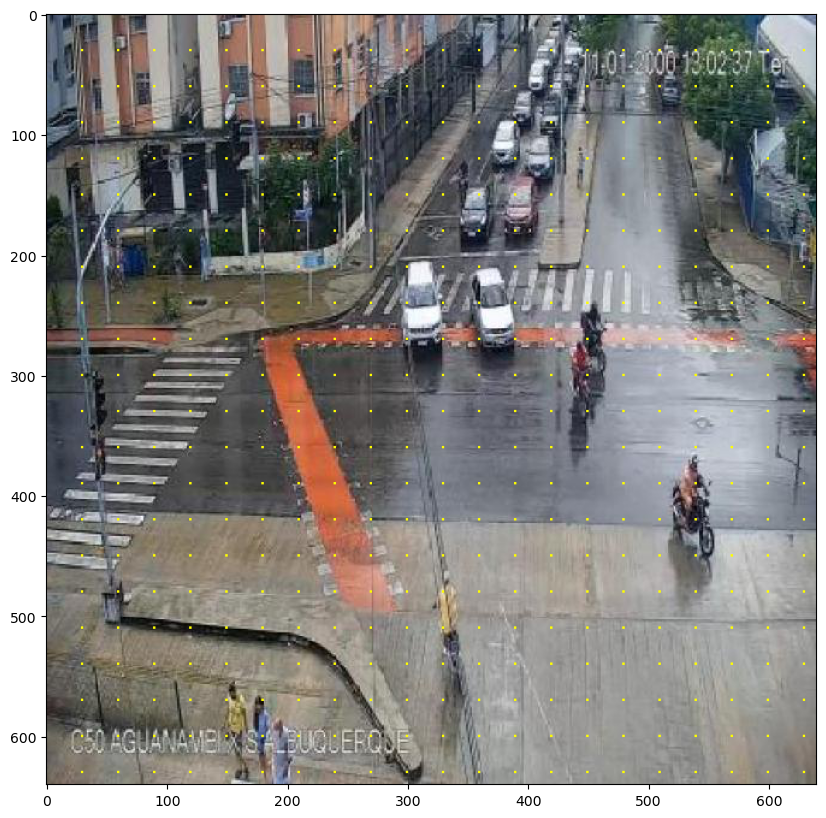

In [108]:
anchor_point_stride = 30
anchor_points = generate_anchor_points(image, anchor_point_stride)
anchor_points_image = add_anchor_points(image, anchor_points, 1)
plt.figure(figsize=(10, 10))
plt.imshow(anchor_points_image)

In [109]:
# The number of anchor points for an image
anchor_points.__len__(), ((image.shape[0] - anchor_point_stride) / anchor_point_stride) * ((image.shape[1] - anchor_point_stride) / anchor_point_stride)

(441, 413.4444444444444)

In [110]:
def generate_regions(anchor_points, region_ratios, region_scales):
    # Going for each anchor point
    regions = []
    for anchor in anchor_points:
        for ratio in region_ratios:
            for scale in region_scales:
                value = 1 * scale
                width = ratio[0] * value
                height = ratio[1] * value
                regions.append([anchor[0], anchor[1], width, height])
    return regions

def add_regions(image, regions, color=[0, 0, 0], thickness = 1):
    new_image = image.copy()
    index = 0
    for region in regions:
        x = region[0]
        y = region[1]
        width = region[2]
        height = region[3]
        topleft = [0 if x - width < 0 else x - width, 0 if y - height < 0 else y - height]
        topright = [image.shape[0] if x + width > image.shape[0] else  x + width, 0 if y - height < 0 else y - height]
        bottomleft = [0 if x - width < 0 else x - width, image.shape[1] if y + height > image.shape[1] else y + height]
        bottomright = [image.shape[0] if x + width > image.shape[0] else x + width, image.shape[1] if y + height > image.shape[1] else y + height]
        chosen_color = color[int(index / len(color))]
        index += 1
        new_image[topleft[0] : topright[0], topleft[1]:topleft[1] + thickness, :] = chosen_color
        new_image[topright[0]:topright[0] + thickness, topright[1]:bottomright[1], :] = chosen_color
        new_image[bottomleft[0] : bottomright[0], bottomleft[1] - thickness : bottomleft[1], :] = chosen_color
        new_image[bottomleft[0] - thickness : bottomleft[0], topleft[1]:bottomleft[1], :] = chosen_color
    return new_image

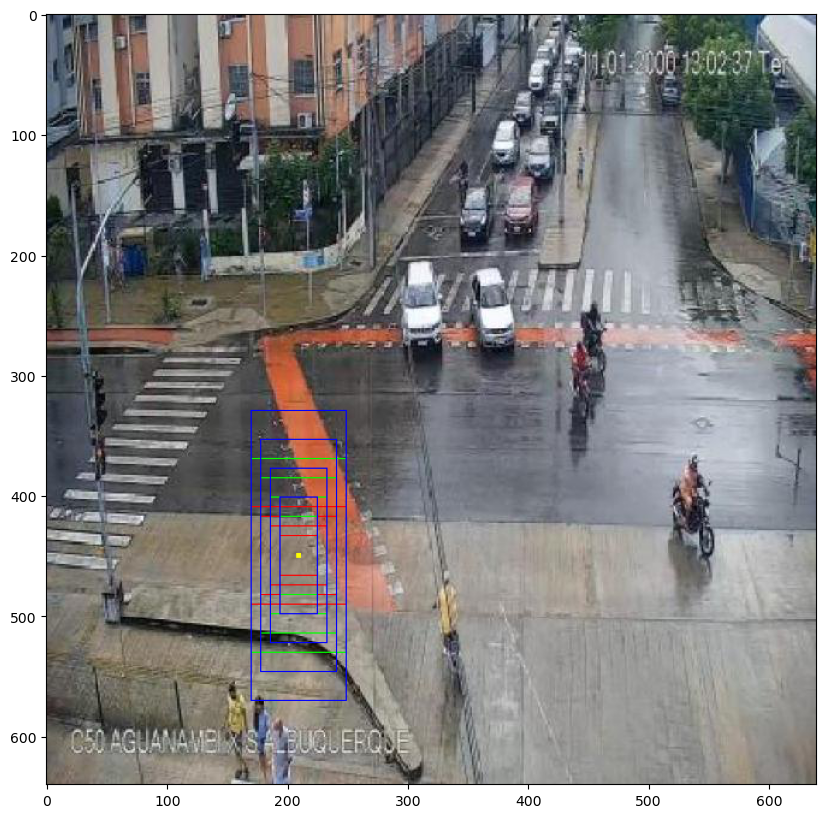

In [111]:
points = anchor_points
region_ratios = [[1, 1], [2, 1], [3, 1]]
region_scales = [16, 24, 32, 40]
regions = generate_regions(points, region_ratios, region_scales)

# Test Points
test_points = [points[300]]
test_regions = generate_regions(test_points, region_ratios, region_scales)
regioned_image = add_regions(image, test_regions, [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]], 1)
regioned_image = add_anchor_points(regioned_image, test_points, 2)
plt.figure(figsize=(10, 10))
plt.imshow(regioned_image)

In [112]:
print(f'Anchor Points: {len(anchor_points)}')
print(f'Regions: {len(regions)}')
print(f'Regions Calculation: {len(anchor_points) * len(region_ratios) * len(region_scales)}')

Anchor Points: 441
Regions: 5292
Regions Calculation: 5292


In [113]:
# Generating Masks for each object in the image
def generate_masks(image, x, y, width, height, flip= False):
    mask = np.zeros(image.shape)
    if flip:
        mask[x - width : x + width, y - height : y + height, :] = [1, 1, 1]
    else:
        mask[y - height : y + height, x - width : x + width, :] = [1, 1, 1]
    return mask

# Checks whether the region goes out of the iamge at any side or not
def is_region_inside_image(image, region):
    x = region[0]
    y = region[1]
    width = region[2]
    height = region[3]

    if x - width < 0 or x + width > image.shape[0] or y - height < 0 or y + height > image.shape[1]:
        return False
    else:
        return True

def find_IOU(label_mask, region_mask):
    new_mask = label_mask[region_mask == 1]
    new_mask = new_mask[new_mask == 1]
    mask1 = label_mask[label_mask == 1]
    mask2 = region_mask[region_mask == 1]
    intersection_area = new_mask.shape[0] / 3.
    total_area = mask1.shape[0] / 3. + mask2.shape[0] / 3. - intersection_area
    return intersection_area / total_area

def show_overlapping_area(region_mask, object_mask):
    main_mask = region_mask
    main_mask[main_mask == 1] = 0.5
    object_mask = object_mask
    object_mask[object_mask == 1] = 0.5
    combined_mask = main_mask + object_mask
    return combined_mask

In [114]:
masks = []
for coords in object_coordinates:
    masks.append(generate_masks(image, coords[1], coords[2], coords[3], coords[4]))
len(masks)

27

In [115]:
regions_masks = []
region_targets = []
object_masks = []
for region in tqdm(regions):
    if is_region_inside_image(image, region):
        region_mask = generate_masks(image, region[0], region[1], region[2], region[3], True)
        for i in range(len(masks)):
            iou = find_IOU(masks[i], region_mask)
            if iou > 0.5 or (iou < 0.3 and iou > 0):
                region_targets.append([1 if iou > 0.5 else 0, iou, object_coordinates[i][0], region[0], region[1], region[2], region[3]])
                # Storing only 1 mask to display the overlapping region
                if iou > 0.5:
                    regions_masks.append(region_mask)
                    object_masks.append(masks[i])

100%|██████████| 5292/5292 [07:47<00:00, 11.33it/s]


In [99]:
def propose_regions(image, object_coordinates, anchor_point_stride = 20, region_ratios = [[1, 1], [2, 1], [3, 1]], region_scales = [16, 24, 32, 40], iou_limit = 0.5):

    # Generating masks
    masks = []
    for coords in object_coordinates:
        masks.append(generate_masks(image, coords[1], coords[2], coords[3], coords[4]))

    anchor_points = generate_anchor_points(image, anchor_point_stride)
    regions = generate_regions(anchor_points, region_ratios, region_scales)
    region_targets = []
    for region in tqdm(regions):
        if is_region_inside_image(image, region):
            region_mask = generate_masks(image, region[0], region[1], region[2], region[3], True)
            for i in range(len(masks)):
                iou = find_IOU(masks[i], region_mask)
                if iou > iou_limit or (iou < 0.3 and iou > 0):
                    region_targets.append([1 if iou > 0.5 else 0, iou, object_coordinates[i][0], region[0], region[1], region[2], region[3]])
    return region_targets

In [116]:
len(regions_masks), len(region_targets)

(116, 5002)

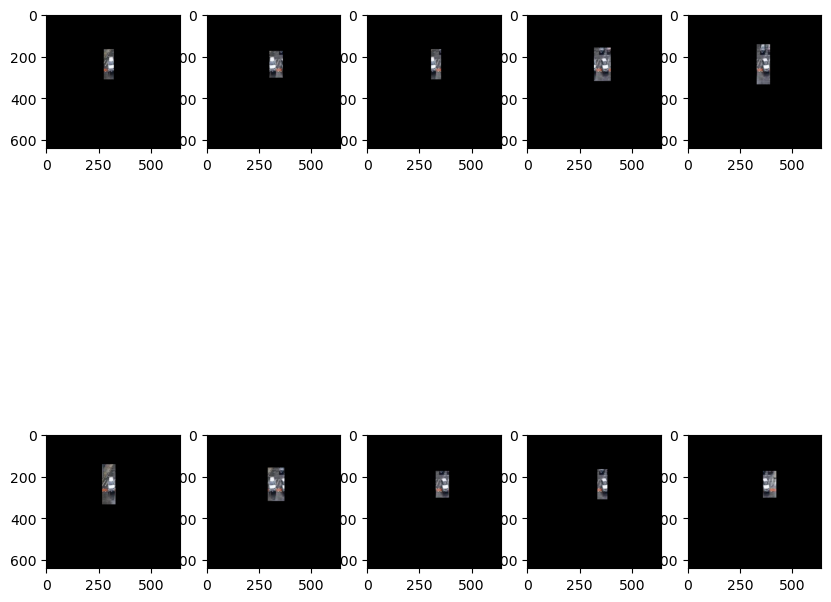

In [125]:
fig, axs = plt.subplots(2, 5, figsize=(10, 10))
index = 50

for i in range(5):
    for j in range(2):
        if index > len(regions_masks) - 1:
            break
        region_mask = regions_masks[index]
        index += 1
        new_image = image.copy()
        new_image[region_mask != 1] = 0
        axs[j, i].imshow(new_image)

In [84]:
def resize_region(image, region, new_size = (64, 64)):
    x = region[3]
    y = region[4]
    width = region[5]
    height = region[6]
    cropped_image = image[x - width: x + width, y - height : y + height, :]
    cropped_image = np.reshape(cropped_image, (width * 2, height * 2, 3))
    cropped_image = cv2.resize(cropped_image, new_size)
    return cropped_image

(80, 80, 3)


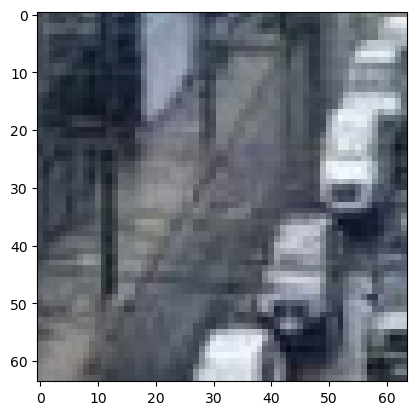

In [67]:
region = region_targets[224]
x = region[3]
y = region[4]
width = region[5]
height = region[6]
cropped_image = image[x - width: x + width, y - height : y + height, :]
cropped_image = np.reshape(cropped_image, (width * 2, height * 2, 3))
print(cropped_image.shape)
cropped_image = cv2.resize(cropped_image, (64, 64))
plt.imshow(cropped_image)

  0%|          | 0/11532 [00:00<?, ?it/s]

100%|██████████| 11532/11532 [11:15<00:00, 17.06it/s] 


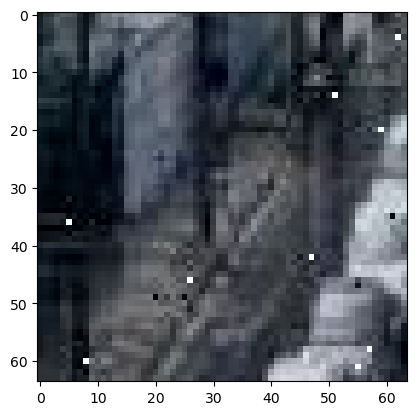

In [100]:
# Defining the algorithm for loading all the images
for i in range(len(images)):
    image, coords = load_image(images, labels, i)
    target_regions = propose_regions(image, coords)
    cropped_image = resize_region(image, target_regions[50])
    plt.imshow(cropped_image)
    break

In [17]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, batch_size = 32):
        self.folder = folder
        self.batch_size = batch_size
        self.images = os.listdir(f'{folder}/images')
        self.labels = os.listdir(f'{folder}/labels')
    
    def __len__(self):
        return self.images.__len__()
    
    def __getitem__(self, index):
        X = []
        y = []
        for i in range(index, index + self.batch_size):
            image = plt.imread(f'{self.folder}/images/{self.images[i]}')
            label = open(f'{self.folder}/labels/{self.labels[i]}').readlines()

Found 5805 files belonging to 2 classes.
